In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from KVClusterV2 import KVClusterV2
from sklearn.manifold import TSNE

In [5]:
# Train
plot_directory = 'result/plot_set'
num_clusters = 10

In [6]:
# colors = [
#     '#e6194B',
#     '#f58231',
#     '#9A6324',
#     '#911eb4',
#     '#3cb44b',
#     '#f032e6',
#     '#4363d8',
# ]

In [7]:
colors = [
		'#FF0000',
		'#00FFFF',
		'#0000FF',
		'#00008B',
		'#ADD8E6',
		'#800080',
		'#7FFFD4',
		'#008000',
		'#FF00FF',
		'#FFC0CB',
		'#C0C0C0',
		'#FFA500',
		'#000000',
		'#800000',
]

In [8]:
def load_json_file(file_path):
	try:
		with open(file_path, 'r') as file:
			data = json.load(file)
		return data
	
	except Exception as e:
		print(f"An error occurred while loading the JSON file: {e}")
		return None

In [9]:
def extract_fpss(metric_list):
	return list(metric_list[list(metric_list.keys())[0]][0]['metric'].keys())

In [10]:
def to_accuracy_vector(accuracy_result_seq, fpss, type='F1'):
		accuracy_vector = []
		for fps in fpss:
				accuracy_vector.append(accuracy_result_seq[fps][type])
		
		return accuracy_vector

In [11]:
def plot_scatter(xs, ys, x_label, y_label, title, fig_size=(8, 8)):
	plt.figure(figsize=fig_size)
	plt.scatter(xs, ys, c=colors[0], s=30, alpha=0.5)
	plt.title(title)
	plt.xlabel(x_label)
	plt.ylabel(y_label)
	plt.show()

In [12]:
def plot_scatter_label(xs, ys, labels, x_label, y_label, title, fig_size=(8, 8)):
	plt.figure(figsize=fig_size)
	for i in range(len(xs)):
		plt.scatter(xs[i], ys[i], c=colors[labels[i]], s=30, alpha=0.5)
	plt.title(title)
	plt.xlabel(x_label)
	plt.ylabel(y_label)
	plt.show()

In [13]:
def filter_list_index(input_list, indices_to_remove):
		return [item for i, item in enumerate(input_list) if i not in indices_to_remove]

## Plot

In [14]:
plot_filenames = sorted(os.listdir(plot_directory))
plot_video_names = sorted(list(set([f.split('_')[0] for f in plot_filenames])))

In [15]:
fpss = extract_fpss(load_json_file(os.path.join(plot_directory, plot_video_names[0] + "_Accuracy_Result.json")))

In [16]:
np.random.seed(42)

In [17]:
omv_lists = []
label_lists = []
clip_amounts = []

for v in plot_video_names:
	cluster = KVClusterV2(num_clusters)
	
	accuracy_result = load_json_file(os.path.join(plot_directory, v + "_Accuracy_Result.json"))
	movement_result = load_json_file(os.path.join(plot_directory, v + "_Movement_Result.json"))

	for class_idx in list(accuracy_result.keys()):
		for i in range(len(accuracy_result[class_idx])):
			accuracy_vector = to_accuracy_vector(accuracy_result[class_idx][i]['metric'], fpss)

			for fps in fpss:
				movement_vector = movement_result[class_idx][i]['movement'][fps]
				cluster.add(movement_vector, accuracy_vector)
	
	cluster.cluster_average()

	# Plot Clusters
	omv_list = [pair[0] for pair in cluster.kv_pairs]
	outlier_index = [i for i in range(len(omv_list)) if omv_list[i][0] == -1]
	omv_list_clean = filter_list_index(omv_list, outlier_index)
	omv_lists.extend(omv_list_clean)

	omv_labels = cluster.self_tell()
	omv_labels_clean = filter_list_index(omv_labels, outlier_index)
	label_lists.extend(omv_labels_clean)

	assert(len(omv_lists) == len(label_lists))
	clip_amounts.append(len(omv_list_clean))

/Users/jiaxili/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jiaxili/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jiaxili/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jiaxili/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init

In [18]:
# Perform t-SNE
high_dimensional_data = np.array(omv_lists)
tsne = TSNE(n_components=2, random_state=42)
low_dimensional_data = tsne.fit_transform(high_dimensional_data)

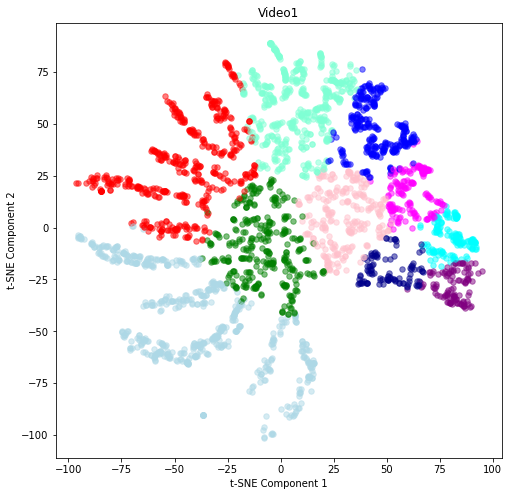

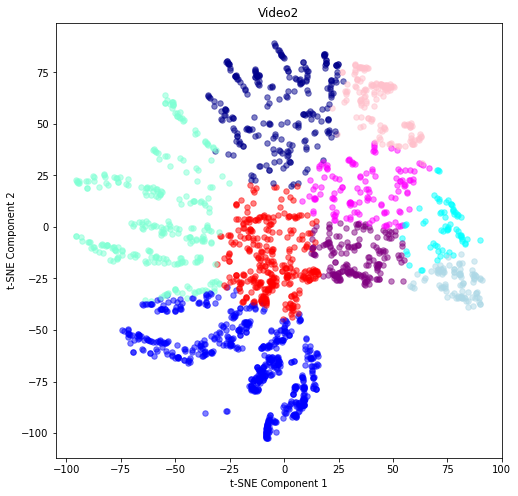

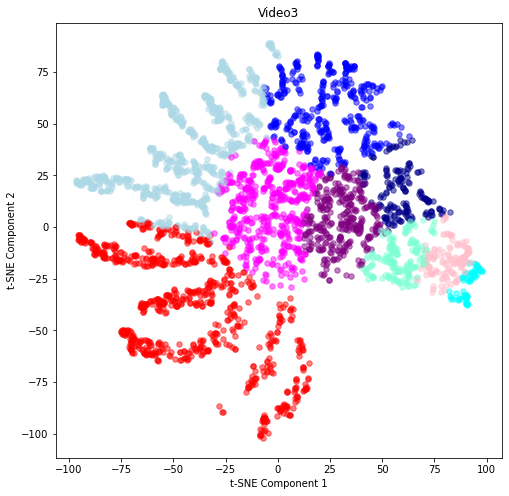

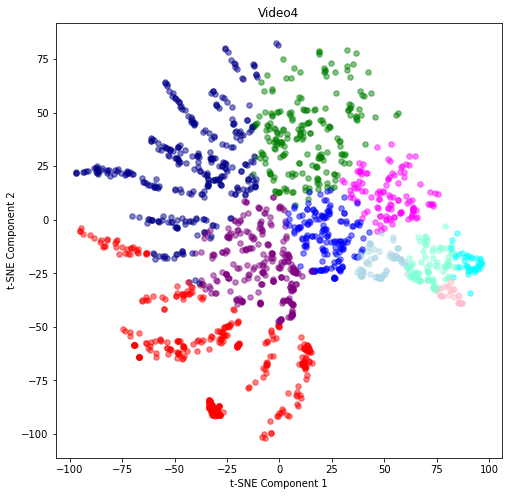

In [24]:
curr_idx = 0
for i in range(len(plot_video_names)):
	video_name = plot_video_names[i]
	ca = clip_amounts[i]

	video_omv_cop1 = low_dimensional_data[curr_idx:curr_idx+ca, 0]
	video_omv_cop2 = low_dimensional_data[curr_idx:curr_idx+ca, 1]
	video_label = label_lists[curr_idx:curr_idx+ca]

	plot_scatter_label(video_omv_cop1, video_omv_cop2, video_label, 't-SNE Component 1', 't-SNE Component 2', video_name)
	curr_idx += ca